## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 2

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.

Nombres:


### Introducción
Una aplicación de música quiere actualizar su aplicación online para que genere recomendaciones a sus usuarios de nuevos artistas para escuchar. El sistema de recomendación debe tomar en cuenta las preferencias de cada usuario, con el fin de ofrecer recomendaciones automáticas y personalizadas.

La base de datos que va a trabajar se ha tomado de http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html


### Enunciado 1
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un algoritmo de recomendación de artistas para cada usuario. Implemente el algoritmo a partir del conjunto de datos: "lastfm-dataset-360K/usersha1-profile.tsv" y evalúe su desempeño con respecto a la métrica apropiada.

Veamos los datos con los que vamos a trabajar:

In [2]:
import pandas
import tarfile
import pandas as pd
import numpy as np
from numpy import loadtxt
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
import pandas as pd
from scipy import stats
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import missingno as msno
import dtale
from pandas_profiling import ProfileReport;

Importamos y descomprimimos los datos:

In [3]:
tf = tarfile.open("lastfm-dataset-360K.tar.gz")
tf.extractall()

Veamos los archivos que hemos importado:

In [4]:
tf.getmembers()

[<TarInfo 'lastfm-dataset-360K' at 0x174ccb56640>,
 <TarInfo 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv' at 0x174ccbe5a00>,
 <TarInfo 'lastfm-dataset-360K/README.txt' at 0x174ccbe5400>,
 <TarInfo 'lastfm-dataset-360K/mbox_sha1sum.py' at 0x174ccbe5dc0>,
 <TarInfo 'lastfm-dataset-360K/usersha1-profile.tsv' at 0x174ccbe5e80>]

Veamos el archivo con la informacion de los usuarios y sus artistas preferidos. Esta base de datos nos dice cuantas veces un usuario a escuchado a un artista.

In [5]:
# leemos el archivo con columnas user/artist/plays
data = pandas.read_table("lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", 
                         usecols=[0, 2, 3], 
                         names=['user', 'artist', 'plays'])

# map each artist and user to a unique numeric value
data['user'] = data['user'].astype("category")
data['artist'] = data['artist'].astype("category")

In [6]:
data.head(10)

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


También podemos ver informacion social/demográfica sobre los usuarios:

In [7]:
# leemos el archivo con columnas user/gender/age/country
dataP = pandas.read_table("lastfm-dataset-360K/usersha1-profile.tsv", 
                         usecols=[0, 1, 2, 3], 
                         names=['user', 'gender', 'age', 'country'])


In [8]:
dataP.head(10)

,user,gender,age,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States
5,0000c176103e538d5c9828e695fed4f7ae42dd01,m,20.0,United Kingdom
6,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,m,17.0,Finland
7,0000ef373bbd0d89ce796abae961f2705e8c1faf,f,22.0,Poland
8,0000f687d4fe9c1ed49620fbc5ed5b0d7798ea20,f,24.0,Spain
9,0001399387da41d557219578fb08b12afa25ab67,m,NaN,Ukraine


In [9]:
# Comenzamos revisando la base

data.isnull().sum()

user        0
artist    204
plays       0
dtype: int64

In [10]:
# Eliminaremos los datos valores faltantes de artistas

data = data.dropna()
data.isnull().sum()

user      0
artist    0
plays     0
dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17535451 entries, 0 to 17535654
Data columns (total 3 columns):
 #   Column  Dtype   
---  ------  -----   
 0   user    category
 1   artist  category
 2   plays   int64   
dtypes: category(2), int64(1)
memory usage: 426.3 MB


In [12]:
# Evaluamos la cantidad de usuarios y de artistas

pd.DataFrame(data["user"].value_counts())
pd.DataFrame(data["artist"].value_counts())

,user
2040b3d3cb47caace19e728090a88d6b1087aa8e,166
13c0df8a58cd3ca9e37d8e90662d2ad3c062eaa5,166
52bf0682648b44e6cc27ebe512dd4fa3455a11c2,150
7679da839e1a6c2d299c7fd6834fb9bf6e229224,139
8d8643cded0ac18e66a3c5a2b74de21fbca0e6b7,132
...,...
fdb8cd010228f711cecc2ed0430795af2d07a907,1
0a19ba55e02f6dc6f583289b589250df1528cbf9,1
0b4688de02bb80f602914deae0b65eac1f311fe0,1
9375eab9f22dbd83e308e64e9670f3a0c0228ab8,1


,artist
radiohead,77254
the beatles,76245
coldplay,66658
red hot chili peppers,48924
muse,46954
...,...
jim sturgess/jim sturgess,1
jim sturgess and dana fuchs,1
jim sturgess +,1
jim stringer & the am band,1


In [13]:
# Observamos que mas de 130.000 artistas tienen menos de una reproduccion
a=pd.DataFrame(data["artist"].value_counts())
a.loc[a.artist<2]

,artist
concern,1
david garibaldi,1
dark skinned assassin,1
david guetta chris will vs tocadisco,1
classical philharmonie bonn & heribert beissel,1
...,...
jim sturgess/jim sturgess,1
jim sturgess and dana fuchs,1
jim sturgess +,1
jim stringer & the am band,1


In [14]:
# Observamos que hay 35 usuarios tienen menos de una reproduccion
a=pd.DataFrame(data["user"].value_counts())
shape(a.loc[a.user<2])

(35, 1)

# Realizaremos un EDA para conocer mejor nuestros datos

In [15]:
data.groupby('user')['plays'].count().reset_index().sort_values('plays', ascending=False).tail(10)

,user,plays
141545,651b9321de4c9d7c5a3e1bea6bfdb9cdbbf88e0c,1
61249,2bbae7ea76e77f8bd500bd3499267c0d43cee75a,1
160263,727ea7fae9190199803d0e3da5dab77e3a3ef056,1
271277,c1cb4c8a0aa87b8198a4c8ef795e2b7b67ba5933,1
36653,1a297e272910f70edafe15fa83e0c9813201c3d8,1
272322,c28635c3fd73cb60670b9e77a97a4e8daa731287,1
231065,a52203df0957b04eec217a2e704b0ce0023df6d7,1
15765,0b4688de02bb80f602914deae0b65eac1f311fe0,1
121456,56cc40cd9cd16229b58d11571ca30bf49d869835,1
40846,1d25471523662e407340463f15353c752dab7bb7,1


In [16]:
data[data.user=="2040b3d3cb47caace19e728090a88d6b1087aa8e"].shape

(166, 3)

In [17]:
# Eliminamos los valores de cero
data=data.loc[data.plays!=0]
data.head()

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


In [18]:
# Calculamos la popularidad de cada artista, que definimos como el numero de usarios distintos que ha reproducido este artista al menos una vez

pop = pd.DataFrame(data["artist"].value_counts())
max_pop=pop.artist.max()

pop["popularidad"]=100*pop.artist/max_pop

In [19]:
# Nos quedamos con los artistas que se consideran con un 90% de popularidad
pop=pop.loc[pop.popularidad>10]
pop=pop.drop(columns=['artist'])
pop=pop.reset_index()
pop=pop.rename(columns={"index":"artist"})
pop

,artist,popularidad
0,radiohead,100.000000
1,the beatles,98.693919
2,coldplay,86.284205
3,red hot chili peppers,63.328760
4,muse,60.778730
...,...,...
325,cansei de ser sexy,10.082326
326,john lennon,10.047376
327,simple plan,10.037021
328,counting crows,10.030549


In [20]:
data_pop=pd.merge(data,pop,on='artist').sort_values('popularidad', ascending=False)

In [21]:
pd.DataFrame(data_pop["user"].value_counts())

,user
a0cfae283411e8aa64dad97c227085d33d83a728,61
4ec0e6419057c21fdcb2666f3fdee4230799b0f9,55
46049f7eceb9766afc773ef531740ad2704fc681,53
577266a0ed80c9b5d92aff0e0522a58673b18ba0,53
2f313b3f3554ef442106178532473a2ab3f43440,52
...,...
50c04cf9304e6ad4394326cb9bfc1b18a053f4ad,0
b61c0a188cbc1187b56ed1df9309d15a43f6983e,0
b516cf218050dd2b4d606fc4c4caf8b094d7bf62,0
8d326a987ce4407e0b7124c36bdd6aab102a0181,0


In [22]:
# Calificacion de peliculas basada en la ponderacion de su rating 
def rating_ponderado(x):
    """
    Input:
    x: datos de rating y votacion de las peliculas
    m: minimo numero de votos
    Output:
    rating ponderado
    """
    m = x['popularidad'].max()
    v = x['plays']
    R = x['popularidad']
    return (v/(v+m) * R) 

In [23]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

# si tiene al menos vmin reproducciones, incluimos el usuario
vmin = 50
data_pop = data_pop.copy().loc[data_pop['plays'] >= vmin]
data_pop['score'] = rating_ponderado(data_pop)

# ordenamos las peliculas de acuerdo con el score
data_pop = data_pop.sort_values('score', ascending=False)

data_pop.head(15)

,user,artist,plays,popularidad,score
930428,c6888d7be46acf6deab52f7bc2bd5900a1b216ba,radiohead,106639,100.0,99.906314
890741,43173c1fc1fffef1f7d481d571ce19656c495df9,radiohead,68518,100.0,99.854266
893674,4c8e5d827c3219927d7d335625c6a59678ca5a82,radiohead,55763,100.0,99.820991
893784,4ceadb2cfa7b1e44d48e9904c7792630ca4b50da,radiohead,43477,100.0,99.770521
921991,aada51348fe151280e630d66c0ddbaa1e7566819,radiohead,36962,100.0,99.730182
919109,a13a2344b16262bbac1bce059f73d4123568edd0,radiohead,36170,100.0,99.724290
905218,72d19ef6bbbba8088d7bd491f463be6f359bd6fb,radiohead,28597,100.0,99.651532
915222,9448878c7a1755f1dae3a186a0690913e1f19eee,radiohead,26714,100.0,99.627060
928695,c0cd9afa71e2993beef42211171b398c74ab9359,radiohead,19822,100.0,99.498042
876517,13740668a22289971f8a5f0aabecac7a24438c58,radiohead,19138,100.0,99.480195


In [24]:
# Ajustamos la lista de las reproucciones de los usuarios

usuarios = data_pop.apply(lambda x: pd.Series(x['user']),axis=1).stack().reset_index(level=1, drop=True)
usuarios.name = 'use'
user_md = data_pop.drop('user', axis=1).join(usuarios)

user_md

,artist,plays,popularidad,score,use
930428,radiohead,106639,100.000000,99.906314,c6888d7be46acf6deab52f7bc2bd5900a1b216ba
890741,radiohead,68518,100.000000,99.854266,43173c1fc1fffef1f7d481d571ce19656c495df9
893674,radiohead,55763,100.000000,99.820991,4c8e5d827c3219927d7d335625c6a59678ca5a82
893784,radiohead,43477,100.000000,99.770521,4ceadb2cfa7b1e44d48e9904c7792630ca4b50da
921991,radiohead,36962,100.000000,99.730182,aada51348fe151280e630d66c0ddbaa1e7566819
...,...,...,...,...,...
600553,dimmu borgir,50,10.022782,3.340927,d94945d345a236e53baa8f5ac369c48521af8ba1
594982,dimmu borgir,50,10.022782,3.340927,20a72f02c10a8351e76995164b482eede9b729b1
601215,dimmu borgir,50,10.022782,3.340927,eefa738e68f6943e9f936a97cb72aa44c4abd394
596299,dimmu borgir,50,10.022782,3.340927,4ccac1503df365af91aab9203cb442943c4510ee


In [25]:
# Definimos la funcion del sistema de recomendacion de artistas:

def rec_artist(usuario, vmin,k):
    
    '''
    usuario: Es el id del usuario al que se le realizará la recomendacion
    vmin: Es el numero de reproducciones minimas para las que se tendrá en cuenta los datos de usuario
    k: Es el numero maximo de artistas recomendados por el sistema para el usuario dado    
    '''
    
    df = user_md[user_md['use'] == usuario]
    
    artistG = df[(df['plays'] >= vmin) & (df['plays'].notnull()) & (df['popularidad'].notnull())]
    

    artistG = artistG.sort_values('score', ascending=False).head(k)
    
    return artistG

In [26]:
# Realizamos nuestra primera recomendacion:
rec_artist('43173c1fc1fffef1f7d481d571ce19656c495df9',100,5)

,artist,plays,popularidad,score,use
890741,radiohead,68518,100.000000,99.854266,43173c1fc1fffef1f7d481d571ce19656c495df9
1514061,metallica,724,58.551014,51.445308,43173c1fc1fffef1f7d481d571ce19656c495df9
3131246,nine inch nails,2136,37.468610,35.792912,43173c1fc1fffef1f7d481d571ce19656c495df9
3087714,rammstein,4209,35.158050,34.342129,43173c1fc1fffef1f7d481d571ce19656c495df9
830970,massive attack,828,37.138530,33.136533,43173c1fc1fffef1f7d481d571ce19656c495df9


In [27]:
# Probamos el sistema para otro usuario
rec_artist(usuarios[5001], 100,10)

,artist,plays,popularidad,score,use
1528758,metallica,206,58.551014,39.416695,96870873d6a543d7168ef09f37c41f6ba9c24296
2400977,green day,482,37.191602,30.801292,96870873d6a543d7168ef09f37c41f6ba9c24296
1491666,ac/dc,367,33.242292,26.124028,96870873d6a543d7168ef09f37c41f6ba9c24296
3806474,johnny cash,157,34.490123,21.069842,96870873d6a543d7168ef09f37c41f6ba9c24296
3140606,nine inch nails,118,37.468610,20.281174,96870873d6a543d7168ef09f37c41f6ba9c24296
2140965,rise against,547,18.919409,15.995234,96870873d6a543d7168ef09f37c41f6ba9c24296
3641324,slipknot,104,24.156678,12.315169,96870873d6a543d7168ef09f37c41f6ba9c24296
3047724,disturbed,139,21.171719,12.313259,96870873d6a543d7168ef09f37c41f6ba9c24296
3117031,nickelback,116,20.681130,11.106533,96870873d6a543d7168ef09f37c41f6ba9c24296
1734320,bullet for my valentine,334,14.163668,10.900150,96870873d6a543d7168ef09f37c41f6ba9c24296


# Comenzaremos con el uso del modelo Sur_Prise

In [28]:
import surprise

from surprise import Reader
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import LeaveOneOut

In [29]:
reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(data_pop[['user', 'artist', 'score']], reader)

data

In [30]:
benchmark = []
# Implementamos validacion cruzada sobre todos los algoritmos
for algoritmo in [SVD(), NMF(), NormalPredictor(), BaselineOnly(), CoClustering()]:
    
    print("\nAlgoritmo: ", algoritmo)
    tiempo = datetime.datetime.now()
    print('\nInicia la validacion cruzada: ', tiempo)
    
    results = cross_validate(algoritmo, data, measures=['RMSE'], cv=3, verbose=False)
    
    tiempo = datetime.datetime.now()
    print('\nTermina: ', tiempo)
    
    # Guardamos los resultados
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algoritmo).split(' ')[0].split('.')[-1]], index=['Algoritmo']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algoritmo').sort_values('test_rmse')  


Algoritmo:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000174ECD9E0A0>

Inicia la validacion cruzada:  2020-12-12 22:44:00.168421

Termina:  2020-12-12 22:55:55.160672

Algoritmo:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000174ECDA6FD0>

Inicia la validacion cruzada:  2020-12-12 22:55:55.161666

Termina:  2020-12-12 23:09:10.180304

Algoritmo:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x00000174ECD9E070>

Inicia la validacion cruzada:  2020-12-12 23:09:10.184295

Termina:  2020-12-12 23:10:36.482322

Algoritmo:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x00000174CA228130>

Inicia la validacion cruzada:  2020-12-12 23:10:36.485314
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...

Termina:  2020-12-12 23:12:24.928457

Algoritmo:  <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x00000174CA228C10>

Inicia la v

,test_rmse,fit_time,test_time
Algoritmo,,,
BaselineOnly,5.323089,14.795745,12.274537
SVD,6.374058,211.328283,16.146532
CoClustering,6.779559,158.942944,14.833247
NMF,15.917689,239.392560,15.608420
NormalPredictor,19.499258,5.902463,14.072016


### De esta manera seleccionamos el algoritmo base para la estimacion de la matriz de factores el metodo *BaselineOnly*, por su menor error visto a traves de su RMSE y por el tiempo de ejecucion.

In [31]:
bsl_options = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 12, 
               'reg_i': 5  
               }

trainset, testset = train_test_split(data, test_size=0.3)

Base = BaselineOnly(bsl_options=bsl_options)

print("\nBaselineOnly: ")
tiempo = datetime.datetime.now()
print('\nInicia el entrenamiento y prueba: ', tiempo)

predBase = Base.fit(trainset).test(testset)
print("\nRMSE del BaselineOnly: ", accuracy.rmse(predBase))

tiempo = datetime.datetime.now()
print('\nTermina: ', tiempo)


BaselineOnly: 

Inicia el entrenamiento y prueba:  2020-12-12 23:21:48.333977
Estimating biases using als...
RMSE: 5.2590

RMSE del BaselineOnly:  5.258951871855621

Termina:  2020-12-12 23:22:30.636116


In [32]:
def items(uid):
    """ 
    Input:
    uid: el id del usuario
    Output: 
    items calificados por el usuario
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # no se encuentra el usuario
        return 0
    
def usuarios(iid):
    """ 
    Input: 
    iid: el id del item
    Output:
    usuarios que han calificado el item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predBase, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Num_Artistas'] = df.uid.apply(items)
df['Num_Usuarios'] = df.iid.apply(usuarios)
df['Error'] = abs(df.est - df.rui)

mejores = df.sort_values(by='Error')[:10]
peores = df.sort_values(by='Error')[-10:]

In [33]:
mejores[['Num_Artistas','Num_Usuarios','uid','iid','rui','est','Error']]

,Num_Artistas,Num_Usuarios,uid,iid,rui,est,Error
622101,16,4422,1f13d89384c0df6c2b516c2426c053926d3e0e8c,the police,10.101161,10.101169,0.000007
1092047,6,14115,fdf110a631e640903580b5d3b71c3d3d19a1dedd,the white stripes,20.041617,20.041605,0.000012
821934,7,12871,ab8df861f05c2ec3f0af8f40e48e18a2d0c908ce,the prodigy,20.568140,20.568126,0.000015
1064887,20,7397,d34511515b64370051b864093c83ddb32c0f5876,nickelback,12.964290,12.964275,0.000015
356167,10,5739,292e2523deabc40d32ce28dc117bc93f46c67858,pendulum,7.394153,7.394127,0.000025
205370,18,6711,10ab8f643b028f0911086347817a88c8aea9d940,sum 41,14.618656,14.618682,0.000026
21471,4,5855,d44936780637a546918a59912c69817e6da0ec4c,jason mraz,10.612046,10.612015,0.000031
1030340,16,4316,996fbeebc3a574a42ca02c81cc9b67413b207af2,klaxons,7.038205,7.038167,0.000038
1111396,13,5640,0e0ebb248a522f6b28e8ddd1b020e0454b9664db,nouvelle vague,8.951439,8.951480,0.000041
366016,11,6336,0683583f7c49c2ce6bfe5052ed3a3248c6fc37b9,lady gaga,12.580935,12.580975,0.000041


In [34]:
print("Se tiene un Artista con muchos usuarios que lo han reproducido: ", 
      np.squeeze(mejores[mejores.iid == "pink floyd"]['Num_Usuarios'])," pink floyd")

print("\nO una Artista con menos usuarios que lo han reproducido: ", 
      np.squeeze(mejores[mejores.iid == "talking heads"]['Num_Usuarios']),"talking heads")

Se tiene un Artista con muchos usuarios que lo han reproducido:  Series([], Name: Num_Usuarios, dtype: int64)  pink floyd

O una Artista con menos usuarios que lo han reproducido:  Series([], Name: Num_Usuarios, dtype: int64) talking heads


In [35]:
peores[['Num_Artistas','Num_Usuarios','uid','iid','rui','est','Error']]

,Num_Artistas,Num_Usuarios,uid,iid,rui,est,Error
261639,2,43220,c68d9c75796d75bbdd57f337e16cb012e533c772,radiohead,33.333333,67.902645,34.569312
989606,8,43841,d2c7d778d14a35928fd5a8ece51c7e68a24dcf8c,the beatles,32.897973,67.501782,34.603809
1100996,9,43841,718aecf634d6703e62bc7ab38fa4c82760306f20,the beatles,32.897973,67.652808,34.754835
681309,6,43841,c2934532c38d218b1e0c9c3710a6d5bb924c5b6a,the beatles,32.897973,67.669025,34.771052
26636,11,43841,8407af155c8cbdaed96d7d47f335ca776d99035b,the beatles,32.897973,67.691485,34.793512
858402,13,43220,f800676d62ce884e4f17ee8ba7cd8289a4495795,radiohead,33.333333,68.224098,34.890765
464023,5,43220,06e9e6e45392687d00da3c0a13a178a6e8c52df7,radiohead,33.774834,68.746186,34.971352
372409,15,43841,8f40419ddb7f0b1a4b348f01d555b67094c4270f,the beatles,33.333708,68.991532,35.657824
1106329,22,43220,ad44e9fee17c55a12ef7ba10e325b95c750e9493,radiohead,35.064935,70.820824,35.755889
673541,12,43220,dac3a361f3963141f800d6a870d96bdb2cf96c8c,radiohead,33.333333,69.377226,36.043892


### Evaluamos nuestro sistema de recomendacion

In [36]:
from surprise import accuracy

In [37]:
accuracy.fcp(predBase, verbose=False)

0.8357899471055198

In [38]:
# Optimizamos los coeficientes para regularizacion

from tqdm import tqdm_notebook as tqdm

ru=(2,5,10,12,15,20)
ri=(2,5,10,12,15,20)

for u,t1 in zip(ru,tqdm(range(6),desc="Iterando Regularizacion u...")):
    for i,t2 in zip(ri,tqdm(range(6),desc="Iterando Regularizacion i...")):
        
        bsl_options = {'method': 'als',
                       'n_epochs': 20,
                       'reg_u': u, 
                       'reg_i': i  
                       }

        trainset, testset = train_test_split(data, test_size=0.3)
        results = cross_validate(BaselineOnly(), data, measures=['fcp'], cv=3, verbose=False)
        Base =BaselineOnly(bsl_options=bsl_options)

        predBase = Base.fit(trainset).test(testset)
        print("Con reg_u: "+str(u) + " reg_i: "+str(i)+
              " --- FCP : "+ str(accuracy.fcp(predBase))+"\n"
             )

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8358
Con reg_u: 2 reg_i: 2 --- FCP : 0.8357500496898106

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8348
Con reg_u: 2 reg_i: 5 --- FCP : 0.8348194035338762

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8356
Con reg_u: 2 reg_i: 10 --- FCP : 0.835552628359037

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8356
Con reg_u: 2 reg_i: 12 --- FCP : 0.8355789369766933

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8355
Con reg_u: 2 reg_i: 15 --- FCP : 0.8354565244844091

Estimating biases using als...
Estimating biases usin

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8357
Con reg_u: 5 reg_i: 2 --- FCP : 0.8356775833274794

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8358
Con reg_u: 5 reg_i: 5 --- FCP : 0.8358273704781104

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8363
Con reg_u: 5 reg_i: 10 --- FCP : 0.8362743244811143

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8352
Con reg_u: 5 reg_i: 12 --- FCP : 0.8352455794879603

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8353
Con reg_u: 5 reg_i: 15 --- FCP : 0.8353302043706012

Estimating biases using als...
Estimating biases usi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8350
Con reg_u: 10 reg_i: 2 --- FCP : 0.8349822460164189

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8358
Con reg_u: 10 reg_i: 5 --- FCP : 0.8358459881100615

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8352
Con reg_u: 10 reg_i: 10 --- FCP : 0.8352234147882921

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8356
Con reg_u: 10 reg_i: 12 --- FCP : 0.8356133488486346

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8355
Con reg_u: 10 reg_i: 15 --- FCP : 0.8354783867530706

Estimating biases using als...
Estimating biase

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8354
Con reg_u: 12 reg_i: 2 --- FCP : 0.8354342981942305

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8357
Con reg_u: 12 reg_i: 5 --- FCP : 0.835740698962093

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8353
Con reg_u: 12 reg_i: 10 --- FCP : 0.8352889087372156

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8354
Con reg_u: 12 reg_i: 12 --- FCP : 0.8354446540072716

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8359
Con reg_u: 12 reg_i: 15 --- FCP : 0.8359187582505931

Estimating biases using als...
Estimating biases

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8354
Con reg_u: 15 reg_i: 2 --- FCP : 0.8354023746656972

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8354
Con reg_u: 15 reg_i: 5 --- FCP : 0.8354084310384314

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8352
Con reg_u: 15 reg_i: 10 --- FCP : 0.8352472043687666

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8356
Con reg_u: 15 reg_i: 12 --- FCP : 0.8355592441199923

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8358
Con reg_u: 15 reg_i: 15 --- FCP : 0.8358165129483662

Estimating biases using als...
Estimating biase

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8353
Con reg_u: 20 reg_i: 2 --- FCP : 0.835290782292663

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8355
Con reg_u: 20 reg_i: 5 --- FCP : 0.8354838870455845

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8356
Con reg_u: 20 reg_i: 10 --- FCP : 0.8355646901749175

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8355
Con reg_u: 20 reg_i: 12 --- FCP : 0.835530174971866

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8359
Con reg_u: 20 reg_i: 15 --- FCP : 0.8358761613943189

Estimating biases using als...
Estimating biases 

### Se hallo el mayor FCP con la combinacion de factores de reguralizazion *u*=5 & *i*=10 para obtener un FCP=0.8363.

In [58]:
# Ajustamos el modelo con los factores de regularizacion finales:

bsl_options = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 5, 
               'reg_i': 10  
               }

trainset, testset = train_test_split(data, test_size=0.3)

Base = BaselineOnly(bsl_options=bsl_options)

predBase = Base.fit(trainset).test(testset)
print("RMSE Optimizado: ", accuracy.rmse(predBase))
print("FCP Optimizado: ", accuracy.fcp(predBase))

Estimating biases using als...
RMSE: 5.1057
RMSE Optimizado:  5.105696191101198
FCP:  0.8358
FCP Optimizado:  0.8358128232732188


### Enunciado 2
Una vez a desarrollado su primer sistema de recomendación, intente mejorarlo con respecto a la métrica de su elección, considerando además la información que encuentra en "lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", donde encuentra información de tipo socio-demográfico por usuario.

In [39]:
# leemos el archivo con columnas user/gender/age/country
dataP = pandas.read_table("lastfm-dataset-360K/usersha1-profile.tsv", 
                         usecols=[0, 1, 2, 3], 
                         names=['user', 'gender', 'age', 'country'])
dataP.head()

,user,gender,age,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States


In [40]:
dataP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359347 entries, 0 to 359346
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user     359347 non-null  object 
 1   gender   326572 non-null  object 
 2   age      284447 non-null  float64
 3   country  359347 non-null  object 
dtypes: float64(1), object(3)
memory usage: 11.0+ MB


In [41]:
dataP=dataP.dropna()

In [42]:
dataP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267383 entries, 0 to 359346
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user     267383 non-null  object 
 1   gender   267383 non-null  object 
 2   age      267383 non-null  float64
 3   country  267383 non-null  object 
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [43]:
dataP= dataP.set_index('user')

In [44]:
# Realizaremos un trabajo de clustering para definir poblaciones similares, sobre las cuales realizaremos modelos calibrados a estas poblaciones

# Importamos el codificador de etiquetas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Identificamos las etiquetas de las categorias
categorical_features = ['gender', 'country']

# Convert the variables to numerical
for i in range(2):
    new = le.fit_transform(dataP[categorical_features[i]])
    dataP[categorical_features[i]] = new

In [45]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(dataP)
    distortions.append(kmeanModel.inertia_);

KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

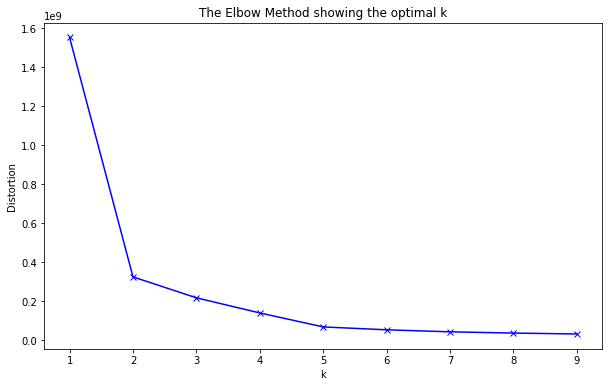

In [46]:
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show();

In [47]:
# Definimos las poblaciones optimas como 5 y aplicamos las etiquetas

kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(dataP)
dataP['Poblacion']=kmeanModel.predict(dataP)

KMeans(n_clusters=5)

In [48]:
dataP

,gender,age,country,Poblacion
user,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,0,22.0,79,2
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,1,19.0,136,3
00007a47085b9aab8af55f52ec8846ac479ac4fe,1,28.0,225,1
0000c176103e538d5c9828e695fed4f7ae42dd01,1,20.0,224,1
0000ee7dd906373efa37f4e1185bfe1e3f8695ae,1,17.0,71,2
...,...,...,...,...
fffe7823f67b433b45f22056467db921c1d3d7d0,1,25.0,79,2
fffe8637bd8234309e871409c7ebef99a720afc1,1,25.0,29,0
fffe8c7f952d9b960a56ed4dcb40a415d924b224,1,20.0,225,1


In [49]:
dataP=dataP.reset_index(level=0, inplace=False)

In [50]:
# Realizaremos la union de las dos bases de datos, usando como identificador el id del usuario
data_dem=pd.merge(data_pop,dataP,on='user')
data_dem

,user,artist,plays,popularidad,score,gender,age,country,Poblacion
0,c6888d7be46acf6deab52f7bc2bd5900a1b216ba,radiohead,106639,100.000000,99.906314,1,24.0,176,3
1,c6888d7be46acf6deab52f7bc2bd5900a1b216ba,coldplay,1446,86.284205,80.703080,1,24.0,176,3
2,c6888d7be46acf6deab52f7bc2bd5900a1b216ba,muse,2038,60.778730,57.935946,1,24.0,176,3
3,c6888d7be46acf6deab52f7bc2bd5900a1b216ba,red hot chili peppers,837,63.328760,56.570087,1,24.0,176,3
4,c6888d7be46acf6deab52f7bc2bd5900a1b216ba,the killers,1490,53.368110,50.011625,1,24.0,176,3
...,...,...,...,...,...,...,...,...,...
2923523,d473576b0e471f6570600e9b638483e561ec5b75,dashboard confessional,50,10.171642,3.390547,0,22.0,224,1
2923524,9f366dd62ab1f69d06599b4b88edfc11228c1893,dimmu borgir,51,10.022782,3.385178,1,19.0,103,2
2923525,698352412f7157b5bdd821035a5c980268387f2a,mando diao,50,10.091387,3.363796,0,17.0,204,1
2923526,fab43683e05fbcf22308ae9288f38c99a779253f,simple plan,50,10.037021,3.345674,1,18.0,170,3


In [51]:
# Separaremos el dataset en las poblaciones definidas dentro de un diccionario:

D_data_dem = {}
D_data = {}
Popu = ["Pob_0","Pob_1","Pob_2","Pob_3","Pob_4"]

for p,i in zip(Popu,range(5)):
    D_data_dem[p]=data_dem.loc[data_dem.Poblacion==i]
    D_data[p] = Dataset.load_from_df(D_data_dem[p][['user', 'artist', 'score']], reader)

In [52]:
# Ajustaremos un modelo por cada poblacion

bsl_options = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 12, 
               'reg_i': 5  
               }
M_RMSE = 0
M_Acc = 0
D_RMSE = {}
D_predBase = {}

for p in Popu:
    
    trainset, testset = train_test_split(D_data[p], test_size=0.3)

    Base = BaselineOnly(bsl_options=bsl_options)

    tiempo = datetime.datetime.now()
    print('\nInicia el entrenamiento y prueba ' + p + " ", tiempo)

    predBase = Base.fit(trainset).test(testset,verbose=False)
    D_predBase[p] = predBase
    D_RMSE[p] = accuracy.rmse(predBase,verbose=False)
    print("RMSE de "+ p + " ", accuracy.rmse(predBase,verbose=False))

    tiempo = datetime.datetime.now()
    print('Termina: ', tiempo)
    
    M_RMSE = M_RMSE + accuracy.rmse(predBase,verbose=False)
    M_Acc = M_Acc + accuracy.fcp(predBase, verbose=False)
    
M_RMSE = M_RMSE/5
M_Acc = M_Acc/5


Inicia el entrenamiento y prueba Pob_0  2020-12-13 01:15:20.980768
Estimating biases using als...
RMSE de Pob_0  5.303346576946517
Termina:  2020-12-13 01:15:25.301218

Inicia el entrenamiento y prueba Pob_1  2020-12-13 01:15:29.922525
Estimating biases using als...
RMSE de Pob_1  5.237632122021776
Termina:  2020-12-13 01:15:43.267900

Inicia el entrenamiento y prueba Pob_2  2020-12-13 01:15:46.979336
Estimating biases using als...
RMSE de Pob_2  5.148535799580349
Termina:  2020-12-13 01:15:51.994505

Inicia el entrenamiento y prueba Pob_3  2020-12-13 01:15:54.962117
Estimating biases using als...
RMSE de Pob_3  5.285968679976246
Termina:  2020-12-13 01:16:00.496084

Inicia el entrenamiento y prueba Pob_4  2020-12-13 01:16:01.633044
Estimating biases using als...
RMSE de Pob_4  12.689077433088514
Termina:  2020-12-13 01:16:01.637041


In [53]:
# Estimamos la media del RMSE para los tres modelos
print("El RMSE medio para todos los modelos es: ", M_RMSE)
print("El FCP medio para todos los modelos es: ", M_Acc)

El RMSE medio para todos los modelos es:  6.732912122322681
El FCP medio para todos los modelos es:  0.8059048407817626


In [57]:
# Procederemos a realizar el ajuste de los coeficientes de regulacion:

for p in Popu:
    
    ru=(2,4,8,10,12,15,20)
    ri=(2,4,8,10,12,15,20)

    print("--------- Ajustando Modelo Poblacion " + p+" ------------")
    for u,t1 in zip(ru,tqdm(range(8),desc="Iterando Regularizacion u...")):
        for i,t2 in zip(ri,tqdm(range(8),desc="Iterando Regularizacion i...")):

            bsl_options = {'method': 'als',
                           'n_epochs': 20,
                           'reg_u': u, 
                           'reg_i': i  
                           }
            trainset, testset = train_test_split(D_data[p], test_size=0.3)
            results = cross_validate(BaselineOnly(), D_data[p], measures=['fcp'], cv=3, verbose=False)
            Base =BaselineOnly(bsl_options=bsl_options)

            predBase = Base.fit(trainset).test(testset)
            print("Con reg_u: "+str(u) + " reg_i: "+str(i)+
                  " --- FCP del Base: "+ str(accuracy.fcp(predBase))+"\n"
                 )

--------- Ajustando Modelo Poblacion Pob_0 ------------


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8373
Con reg_u: 2 reg_i: 2 --- FCP del Base: 0.8373151558530483

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8369
Con reg_u: 2 reg_i: 4 --- FCP del Base: 0.8368555887583011

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8370
Con reg_u: 2 reg_i: 8 --- FCP del Base: 0.8369632867037856

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8365
Con reg_u: 2 reg_i: 10 --- FCP del Base: 0.8364642623094696

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8355
Con reg_u: 2 reg_i: 12 --- FCP del Base: 0.8355188269492178

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8369
Con reg_u: 4 reg_i: 2 --- FCP del Base: 0.8368657704023428

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8370
Con reg_u: 4 reg_i: 4 --- FCP del Base: 0.8369838911155849

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8368
Con reg_u: 4 reg_i: 8 --- FCP del Base: 0.8367557522688731

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8363
Con reg_u: 4 reg_i: 10 --- FCP del Base: 0.8362711438585352

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8367
Con reg_u: 4 reg_i: 12 --- FCP del Base: 0.8367037873457628

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8385
Con reg_u: 8 reg_i: 2 --- FCP del Base: 0.8385464477090896

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8356
Con reg_u: 8 reg_i: 4 --- FCP del Base: 0.8355759097508668

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8373
Con reg_u: 8 reg_i: 8 --- FCP del Base: 0.8373467728639132

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8379
Con reg_u: 8 reg_i: 10 --- FCP del Base: 0.8378873524207943

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8378
Con reg_u: 8 reg_i: 12 --- FCP del Base: 0.8378420154509453

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8382
Con reg_u: 10 reg_i: 2 --- FCP del Base: 0.8382276114925069

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8375
Con reg_u: 10 reg_i: 4 --- FCP del Base: 0.8375387056897101

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8362
Con reg_u: 10 reg_i: 8 --- FCP del Base: 0.8361800976672706

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8372
Con reg_u: 10 reg_i: 10 --- FCP del Base: 0.8372483230281974

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8385
Con reg_u: 10 reg_i: 12 --- FCP del Base: 0.8385424183050033

Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8376
Con reg_u: 12 reg_i: 2 --- FCP del Base: 0.8375952713439171

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8379
Con reg_u: 12 reg_i: 4 --- FCP del Base: 0.8378635451369533

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8374
Con reg_u: 12 reg_i: 8 --- FCP del Base: 0.8373576517809292

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8380
Con reg_u: 12 reg_i: 10 --- FCP del Base: 0.8380000478934423

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8377
Con reg_u: 12 reg_i: 12 --- FCP del Base: 0.8377081754612212

Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8375
Con reg_u: 15 reg_i: 2 --- FCP del Base: 0.8374853488831967

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8370
Con reg_u: 15 reg_i: 4 --- FCP del Base: 0.8369789885520411

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8366
Con reg_u: 15 reg_i: 8 --- FCP del Base: 0.8366314688403204

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8365
Con reg_u: 15 reg_i: 10 --- FCP del Base: 0.8364627434518465

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8369
Con reg_u: 15 reg_i: 12 --- FCP del Base: 0.8368765982622214

Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8385
Con reg_u: 20 reg_i: 2 --- FCP del Base: 0.8385438709792349

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8374
Con reg_u: 20 reg_i: 4 --- FCP del Base: 0.83737511760391

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8375
Con reg_u: 20 reg_i: 8 --- FCP del Base: 0.8374992962172018

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8381
Con reg_u: 20 reg_i: 10 --- FCP del Base: 0.8380638424066985

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8379
Con reg_u: 20 reg_i: 12 --- FCP del Base: 0.8379271753644761

Estimating

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8436
Con reg_u: 2 reg_i: 2 --- FCP del Base: 0.8436417099338968

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8443
Con reg_u: 2 reg_i: 4 --- FCP del Base: 0.8443201966260027

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8446
Con reg_u: 2 reg_i: 8 --- FCP del Base: 0.844555717931121

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8439
Con reg_u: 2 reg_i: 10 --- FCP del Base: 0.8439467054283977

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8437
Con reg_u: 2 reg_i: 12 --- FCP del Base: 0.8436695375356539

Estimating bia

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8443
Con reg_u: 4 reg_i: 2 --- FCP del Base: 0.8443353715276288

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8436
Con reg_u: 4 reg_i: 4 --- FCP del Base: 0.843596247356535

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8438
Con reg_u: 4 reg_i: 8 --- FCP del Base: 0.8437845346856753

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8441
Con reg_u: 4 reg_i: 10 --- FCP del Base: 0.8440709123361813

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8439
Con reg_u: 4 reg_i: 12 --- FCP del Base: 0.843852362273278

Estimating bias

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8435
Con reg_u: 8 reg_i: 2 --- FCP del Base: 0.8434613615090364

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8445
Con reg_u: 8 reg_i: 4 --- FCP del Base: 0.8444882517047122

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8437
Con reg_u: 8 reg_i: 8 --- FCP del Base: 0.8437407355138358

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8446
Con reg_u: 8 reg_i: 10 --- FCP del Base: 0.8446323054164089

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8449
Con reg_u: 8 reg_i: 12 --- FCP del Base: 0.8448940434583667

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8434
Con reg_u: 10 reg_i: 2 --- FCP del Base: 0.8434245838936238

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8441
Con reg_u: 10 reg_i: 4 --- FCP del Base: 0.8440510405116707

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8449
Con reg_u: 10 reg_i: 8 --- FCP del Base: 0.8449265553437205

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8441
Con reg_u: 10 reg_i: 10 --- FCP del Base: 0.8441081237562099

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8432
Con reg_u: 10 reg_i: 12 --- FCP del Base: 0.8432486473398979

Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8449
Con reg_u: 12 reg_i: 2 --- FCP del Base: 0.8449335383801602

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8442
Con reg_u: 12 reg_i: 4 --- FCP del Base: 0.8441923972272254

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8433
Con reg_u: 12 reg_i: 8 --- FCP del Base: 0.843306215304209

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8440
Con reg_u: 12 reg_i: 10 --- FCP del Base: 0.8439983778120903

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8448
Con reg_u: 12 reg_i: 12 --- FCP del Base: 0.8447744134108277

Estimatin

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8432
Con reg_u: 15 reg_i: 2 --- FCP del Base: 0.843205327939854

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8443
Con reg_u: 15 reg_i: 4 --- FCP del Base: 0.8442861150040519

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8442
Con reg_u: 15 reg_i: 8 --- FCP del Base: 0.8442386999773975

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8437
Con reg_u: 15 reg_i: 10 --- FCP del Base: 0.843652173494198

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8454
Con reg_u: 15 reg_i: 12 --- FCP del Base: 0.8453781115491417

Estimating

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8438
Con reg_u: 20 reg_i: 2 --- FCP del Base: 0.8437555654418242

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8441
Con reg_u: 20 reg_i: 4 --- FCP del Base: 0.844070055230386

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8443
Con reg_u: 20 reg_i: 8 --- FCP del Base: 0.8442756886445886

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8442
Con reg_u: 20 reg_i: 10 --- FCP del Base: 0.8442139280756356

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8440
Con reg_u: 20 reg_i: 12 --- FCP del Base: 0.8439934898978795

Estimatin

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8303
Con reg_u: 2 reg_i: 2 --- FCP del Base: 0.830275790908721

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8288
Con reg_u: 2 reg_i: 4 --- FCP del Base: 0.828769873845203

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8295
Con reg_u: 2 reg_i: 8 --- FCP del Base: 0.8294756358536933

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8294
Con reg_u: 2 reg_i: 10 --- FCP del Base: 0.8293712632042038

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8287
Con reg_u: 2 reg_i: 12 --- FCP del Base: 0.8286837119822287

Estimating bias

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8300
Con reg_u: 4 reg_i: 2 --- FCP del Base: 0.8300390971678642

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8281
Con reg_u: 4 reg_i: 4 --- FCP del Base: 0.8281076005369085

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8281
Con reg_u: 4 reg_i: 8 --- FCP del Base: 0.8280680609471686

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8289
Con reg_u: 4 reg_i: 10 --- FCP del Base: 0.8288592788801352

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8287
Con reg_u: 4 reg_i: 12 --- FCP del Base: 0.8286759238486217

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8288
Con reg_u: 8 reg_i: 2 --- FCP del Base: 0.8288367291468861

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8291
Con reg_u: 8 reg_i: 4 --- FCP del Base: 0.8290608500305485

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8287
Con reg_u: 8 reg_i: 8 --- FCP del Base: 0.8286818782081415

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8284
Con reg_u: 8 reg_i: 10 --- FCP del Base: 0.8284319328594011

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8295
Con reg_u: 8 reg_i: 12 --- FCP del Base: 0.8294898613998828

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8287
Con reg_u: 10 reg_i: 2 --- FCP del Base: 0.828656546999555

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8287
Con reg_u: 10 reg_i: 4 --- FCP del Base: 0.8286827733076685

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8282
Con reg_u: 10 reg_i: 8 --- FCP del Base: 0.8281613805561846

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8279
Con reg_u: 10 reg_i: 10 --- FCP del Base: 0.8279297305532717

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8293
Con reg_u: 10 reg_i: 12 --- FCP del Base: 0.8292845462671801

Estimatin

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8293
Con reg_u: 12 reg_i: 2 --- FCP del Base: 0.8292680165373377

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8289
Con reg_u: 12 reg_i: 4 --- FCP del Base: 0.8289388511504984

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8288
Con reg_u: 12 reg_i: 8 --- FCP del Base: 0.8288497157362066

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8288
Con reg_u: 12 reg_i: 10 --- FCP del Base: 0.8287732914439478

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8282
Con reg_u: 12 reg_i: 12 --- FCP del Base: 0.8281606286546093

Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8282
Con reg_u: 15 reg_i: 2 --- FCP del Base: 0.8282410899462785

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8284
Con reg_u: 15 reg_i: 4 --- FCP del Base: 0.8284351562265166

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8292
Con reg_u: 15 reg_i: 8 --- FCP del Base: 0.8291992416161426

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8284
Con reg_u: 15 reg_i: 10 --- FCP del Base: 0.8284044022675022

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8297
Con reg_u: 15 reg_i: 12 --- FCP del Base: 0.829721223544025

Estimatin

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8293
Con reg_u: 20 reg_i: 2 --- FCP del Base: 0.8293144009109678

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8292
Con reg_u: 20 reg_i: 4 --- FCP del Base: 0.8292393764432463

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8302
Con reg_u: 20 reg_i: 8 --- FCP del Base: 0.8302129755049005

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8289
Con reg_u: 20 reg_i: 10 --- FCP del Base: 0.8289445104309374

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8263
Con reg_u: 20 reg_i: 12 --- FCP del Base: 0.8263129557715116

Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8299
Con reg_u: 2 reg_i: 2 --- FCP del Base: 0.8299040662430913

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8326
Con reg_u: 2 reg_i: 4 --- FCP del Base: 0.8326094690164537

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8308
Con reg_u: 2 reg_i: 8 --- FCP del Base: 0.8308489242145516

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8314
Con reg_u: 2 reg_i: 10 --- FCP del Base: 0.8313519398596605

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8302
Con reg_u: 2 reg_i: 12 --- FCP del Base: 0.8302237989930417

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8316
Con reg_u: 4 reg_i: 2 --- FCP del Base: 0.831594215998035

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8303
Con reg_u: 4 reg_i: 4 --- FCP del Base: 0.8303085241558822

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8314
Con reg_u: 4 reg_i: 8 --- FCP del Base: 0.8313764388481693

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8307
Con reg_u: 4 reg_i: 10 --- FCP del Base: 0.830729696236634

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8311
Con reg_u: 4 reg_i: 12 --- FCP del Base: 0.8310918485253753

Estimating bias

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8293
Con reg_u: 8 reg_i: 2 --- FCP del Base: 0.8293316181009898

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8305
Con reg_u: 8 reg_i: 4 --- FCP del Base: 0.8305000510316302

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8306
Con reg_u: 8 reg_i: 8 --- FCP del Base: 0.8305732587063823

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8309
Con reg_u: 8 reg_i: 10 --- FCP del Base: 0.8308680857177434

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8309
Con reg_u: 8 reg_i: 12 --- FCP del Base: 0.8309087484132615

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8324
Con reg_u: 10 reg_i: 2 --- FCP del Base: 0.83239722982691

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8309
Con reg_u: 10 reg_i: 4 --- FCP del Base: 0.8308799946129541

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8303
Con reg_u: 10 reg_i: 8 --- FCP del Base: 0.830283162738084

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8289
Con reg_u: 10 reg_i: 10 --- FCP del Base: 0.8288966239735839

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8308
Con reg_u: 10 reg_i: 12 --- FCP del Base: 0.8307914370330874

Estimating 

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8290
Con reg_u: 12 reg_i: 2 --- FCP del Base: 0.828962221178125

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8301
Con reg_u: 12 reg_i: 4 --- FCP del Base: 0.8301284045838698

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8320
Con reg_u: 12 reg_i: 8 --- FCP del Base: 0.8319803683362618

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8318
Con reg_u: 12 reg_i: 10 --- FCP del Base: 0.8318103108770311

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8301
Con reg_u: 12 reg_i: 12 --- FCP del Base: 0.8301413270910588

Estimatin

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8317
Con reg_u: 15 reg_i: 2 --- FCP del Base: 0.8316536091319104

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8307
Con reg_u: 15 reg_i: 4 --- FCP del Base: 0.8306928180556665

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8314
Con reg_u: 15 reg_i: 8 --- FCP del Base: 0.8313581628214867

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8317
Con reg_u: 15 reg_i: 10 --- FCP del Base: 0.8316783650107177

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8321
Con reg_u: 15 reg_i: 12 --- FCP del Base: 0.8321078676985448

Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8307
Con reg_u: 20 reg_i: 2 --- FCP del Base: 0.8307230043742171

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8322
Con reg_u: 20 reg_i: 4 --- FCP del Base: 0.8321635686398686

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8306
Con reg_u: 20 reg_i: 8 --- FCP del Base: 0.8305599898190995

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8324
Con reg_u: 20 reg_i: 10 --- FCP del Base: 0.8324082401693611

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.8322
Con reg_u: 20 reg_i: 12 --- FCP del Base: 0.832213451292123

Estimatin

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6468
Con reg_u: 2 reg_i: 2 --- FCP del Base: 0.6467964917496655

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.7243
Con reg_u: 2 reg_i: 4 --- FCP del Base: 0.7243305169697838

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6025
Con reg_u: 2 reg_i: 8 --- FCP del Base: 0.6024793388429752

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6633
Con reg_u: 2 reg_i: 10 --- FCP del Base: 0.663287472845764

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6407
Con reg_u: 2 reg_i: 12 --- FCP del Base: 0.6407076969605322

Estimating bia

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5810
Con reg_u: 4 reg_i: 2 --- FCP del Base: 0.5810473815461347

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6731
Con reg_u: 4 reg_i: 4 --- FCP del Base: 0.6731391585760517

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5921
Con reg_u: 4 reg_i: 8 --- FCP del Base: 0.5920679886685553

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6874
Con reg_u: 4 reg_i: 10 --- FCP del Base: 0.6873889875666075

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6354
Con reg_u: 4 reg_i: 12 --- FCP del Base: 0.6354243542435425

Estimating bi

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.7065
Con reg_u: 8 reg_i: 2 --- FCP del Base: 0.7064649243466299

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5939
Con reg_u: 8 reg_i: 4 --- FCP del Base: 0.5939192003331946

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5338
Con reg_u: 8 reg_i: 8 --- FCP del Base: 0.533771667662881

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5771
Con reg_u: 8 reg_i: 10 --- FCP del Base: 0.5770750988142292

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6177
Con reg_u: 8 reg_i: 12 --- FCP del Base: 0.617737003058104

Estimating bias

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5954
Con reg_u: 10 reg_i: 2 --- FCP del Base: 0.59536354056902

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5402
Con reg_u: 10 reg_i: 4 --- FCP del Base: 0.5401929260450161

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6789
Con reg_u: 10 reg_i: 8 --- FCP del Base: 0.6788990825688074

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6261
Con reg_u: 10 reg_i: 10 --- FCP del Base: 0.6260984182776801

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6098
Con reg_u: 10 reg_i: 12 --- FCP del Base: 0.6097666378565254

Estimating

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5928
Con reg_u: 12 reg_i: 2 --- FCP del Base: 0.5928338762214983

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5905
Con reg_u: 12 reg_i: 4 --- FCP del Base: 0.5904879555281037

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6042
Con reg_u: 12 reg_i: 8 --- FCP del Base: 0.6042031523642732

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6703
Con reg_u: 12 reg_i: 10 --- FCP del Base: 0.6703296703296703

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6009
Con reg_u: 12 reg_i: 12 --- FCP del Base: 0.6008728706180487

Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6904
Con reg_u: 15 reg_i: 2 --- FCP del Base: 0.6904315196998124

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6497
Con reg_u: 15 reg_i: 4 --- FCP del Base: 0.6496636771300449

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6865
Con reg_u: 15 reg_i: 8 --- FCP del Base: 0.6865464632454924

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5913
Con reg_u: 15 reg_i: 10 --- FCP del Base: 0.5913095415857846

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6970
Con reg_u: 15 reg_i: 12 --- FCP del Base: 0.696969696969697

Estimatin

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5373
Con reg_u: 20 reg_i: 2 --- FCP del Base: 0.5372945638432364

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6146
Con reg_u: 20 reg_i: 4 --- FCP del Base: 0.61455525606469

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5819
Con reg_u: 20 reg_i: 8 --- FCP del Base: 0.581944865192366

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.5662
Con reg_u: 20 reg_i: 10 --- FCP del Base: 0.5661764705882353

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
FCP:  0.6789
Con reg_u: 20 reg_i: 12 --- FCP del Base: 0.6789077212806026

Estimating 

### Se hallaron los mayores FCP con la combinacion de factores de reguralizazion *u* & *i* mostrados a continuacion:

* Pob-0
Con reg_u: 15 reg_i: 15 --- FCP: 0.8386

* Pob-1
Con reg_u: 15 reg_i: 12 --- FCP: 0.8454

* Pob-2
Con reg_u: 2 reg_i: 2 --- FCP: 0.8303

* Pob-3
Con reg_u: 2 reg_i: 4 --- FCP: 0.8326

* Pob-4
Con reg_u: 2 reg_i: 4 --- FCP: 0.7244

In [66]:
# Procederemos a ajustar el metd-modelo con los parametros optimos, con el fin de obtener su metrica de desempeño:

# Definiremos los factores de regularizacion para cada modelo:

bsl_0 = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 15, 
               'reg_i': 15  
               }

bsl_1 = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 15, 
               'reg_i': 12  
               }

bsl_2 = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 2, 
               'reg_i': 2  
               }


bsl_3 = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 2, 
               'reg_i': 4  
               }

bsl_4 = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 2, 
               'reg_i': 4  
               }

# Creamos un diccionario de los factores de regularizacion de los modelos

D_bsl = {"Pob_0": bsl_0,"Pob_1" : bsl_1,"Pob_2":bsl_2,"Pob_3":bsl_3,"Pob_4":bsl_4}

# Calculamos las metricas del Meta-Modelo

Meta_FPC=0
Meta_RMSE=0

for p in Popu:

    print("\n --------- Ajustando Modelo Poblacion " + p+" ------------")

    bsl_options = D_bsl[p]

    trainset, testset = train_test_split(D_data[p], test_size=0.3)
    Base = BaselineOnly(bsl_options=bsl_options)
    predBase = Base.fit(trainset).test(testset)    
    Meta_FPC = Meta_FPC + accuracy.fcp(predBase)
    Meta_RMSE =  Meta_RMSE + accuracy.rmse(predBase)

Meta_FPC = Meta_FPC/5
Meta_RMSE = Meta_RMSE/5

print("\n-------------------Resultados Finales--------------------------------------")
print("FCP del Meta-Modelo: " + str(round(Meta_FPC,4)))
print("RMSE del Meta-Modelo: " + str(round(Meta_RMSE,4)))


 --------- Ajustando Modelo Poblacion Pob_0 ------------
Estimating biases using als...
FCP:  0.8377
RMSE: 5.3621

 --------- Ajustando Modelo Poblacion Pob_1 ------------
Estimating biases using als...
FCP:  0.8448
RMSE: 5.2708

 --------- Ajustando Modelo Poblacion Pob_2 ------------
Estimating biases using als...
FCP:  0.8290
RMSE: 4.9630

 --------- Ajustando Modelo Poblacion Pob_3 ------------
Estimating biases using als...
FCP:  0.8313
RMSE: 5.0903

 --------- Ajustando Modelo Poblacion Pob_4 ------------
Estimating biases using als...
FCP:  0.6007
RMSE: 11.0080

-------------------Resultados Finales--------------------------------------
FCP del Meta-Modelo: 0.7887
RMSE del Meta-Modelo: 6.3388
